# MNIST example

Althought torchtuples is created to work with arrays/tensors in memory, one can still use it to fit a data set by reading from disk.

This example is based on  [this pytorch example](https://github.com/pytorch/examples/blob/master/mnist/main.py), but rewritten for torchtuples with some other minor modifications.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [2]:
import matplotlib.pyplot as plt
from torchtuples import Model, optim, practical, data

In [3]:
# for reproducability
np.random.seed(123456)
_ = torch.manual_seed(654321)

In [4]:
num_workers = 0
batch_size = 64
batch_size_test = 1000
epochs = 10
lr = 0.01
momentum=0.5

### Dataset 

We load the MNIST datas set from torchvision as two dataloaders: one for training and one for testing.

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [6]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_test, shuffle=False, num_workers=num_workers)

We make a simple covolutional net:

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return  x # return F.log_softmax(x, dim=1)

In [8]:
net = Net()
model = Model(net, nn.CrossEntropyLoss(), optim.SGD(lr, momentum))

and fit the net with SGD. Note that we can use `model.lr_finder_dataloader` to to find a reasonable learning rate, and include callbacks for early stopping etc.

In [9]:
log = model.fit_dataloader(train_loader, epochs=epochs, val_dataloader=test_loader, metrics={'acc': practical.accuracy_argmax})

0:	:30s / 1m:30s],		train_loss: 0.3225,	train_acc: 0.9041,	val_loss: 0.0967,	val_acc: 0.9714
1:	:36s / 3m:7s],		train_loss: 0.0842,	train_acc: 0.9740,	val_loss: 0.0621,	val_acc: 0.9810
2:	:9s / 4m:16s],		train_loss: 0.0597,	train_acc: 0.9818,	val_loss: 0.0489,	val_acc: 0.9844
3:	:12s / 5m:28s],		train_loss: 0.0467,	train_acc: 0.9857,	val_loss: 0.0416,	val_acc: 0.9863
4:	:8s / 6m:37s],		train_loss: 0.0392,	train_acc: 0.9881,	val_loss: 0.0425,	val_acc: 0.9859
5:	:9s / 7m:46s],		train_loss: 0.0334,	train_acc: 0.9901,	val_loss: 0.0315,	val_acc: 0.9910
6:	:5s / 8m:52s],		train_loss: 0.0292,	train_acc: 0.9909,	val_loss: 0.0326,	val_acc: 0.9888
7:	:22s / 10m:15s],		train_loss: 0.0253,	train_acc: 0.9922,	val_loss: 0.0294,	val_acc: 0.9907
8:	:12s / 11m:27s],		train_loss: 0.0227,	train_acc: 0.9933,	val_loss: 0.0256,	val_acc: 0.9910
9:	:8s / 12m:35s],		train_loss: 0.0198,	train_acc: 0.9938,	val_loss: 0.0263,	val_acc: 0.9915


We can plot the loss and accuracy of the training progress

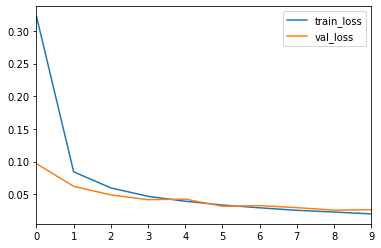

In [10]:
_ = log.to_pandas()[['train_loss', 'val_loss']].plot()

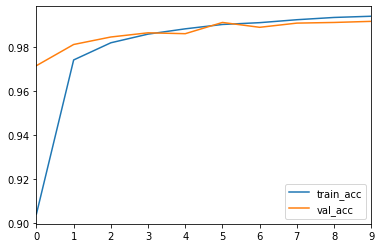

In [11]:
_ = log.to_pandas()[['train_acc', 'val_acc']].plot()

## Scoring

We can either use a method of the model to score the test set, or we can make predictions

In [12]:
model.score_in_batches_dataloader(test_loader)

{'loss': 0.0263050589710474, 'acc': 0.9915000200271606}

### Prections

To use the predit method, we need a data loader that only pass the images and not the labels.

This can be done by making a new data loader, or use the function in `torchtuples.data.dataloader_input_only`

In [13]:
test_input = data.dataloader_input_only(test_loader)

We can now make preditions

In [14]:
preds = model.predict(test_input)
preds = preds.argmax(1)

and visualize by sampling 8 at a time

In [15]:
images = next(iter(test_input))

array([4, 7, 0, 4, 6, 7, 5, 4])

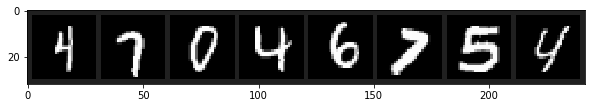

In [16]:
idx = np.random.choice(test_input.batch_sampler.batch_size, 8)
sub = images[idx]
plt.figure(figsize=(10, 6))
_ = plt.imshow(torchvision.utils.make_grid(sub)[0].numpy(), cmap='gray')
preds[idx]